In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()

In [2]:
# Load testing dataset(Daily data)
def read_daily_df(features,file):
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [4]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [5]:
# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [6]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [7]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [8]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [9]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler_y.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [10]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [11]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[df['Date']<test_time[0]]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    #y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler_y.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler_y.inverse_transform(y_test.reshape(-1, 1))
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],
                     hyperparameters['verbose'],hyperparameters['loss_function'])
    index,X,y = sparse_dataset(test_X,Scaler_y.inverse_transform(test_y.reshape(-1, 1))) # index is the time series
    yhat = Scaler_y.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler_y.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [12]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short:')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

Load training data (containing nutrient observations)
Lake name in short:Feeagh
Winter data or not? (Y/N)Y


In [13]:
# Create the daily df with Nan in nutrients columns'
print(all_df.info())
n_Nut = int(input('Number of nutrients: (including Chl)'))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)
Nut = all_df[Nut_f]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           142 non-null    datetime64[ns]
 1   TotN           142 non-null    float64       
 2   TotP           128 non-null    float64       
 3   Chl            142 non-null    float64       
 4   delT           142 non-null    float64       
 5   U              142 non-null    float64       
 6   Air P          142 non-null    float64       
 7   Air T          142 non-null    float64       
 8   RelHum         142 non-null    float64       
 9   CC             142 non-null    float64       
 10  SWR            142 non-null    float64       
 11  Prec           142 non-null    float64       
 12  inflow(m3/s)   142 non-null    float64       
 13  outflow(m3/s)  142 non-null    float64       
 14  MLD            142 non-null    float64       
 15  W              142 non-

In [14]:
n_feature = int(input('Number of features used for basic training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

Number of features used for basic training: 13
Feature:delT
Feature:U
Feature:Air P
Feature:Air T
Feature:RelHum
Feature:CC
Feature:SWR
Feature:Prec
Feature:inflow(m3/s)
Feature:outflow(m3/s)
Feature:MLD
Feature:W
Feature:thermD
['Date', 'delT', 'U', 'Air P', 'Air T', 'RelHum', 'CC', 'SWR', 'Prec', 'inflow(m3/s)', 'outflow(m3/s)', 'MLD', 'W', 'thermD']


In [15]:
# date to seperate training and test sets
YY=all_df['Date'].apply(lambda d:d.year).unique()
print(YY)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),12,31)]

[2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
test starts in year:2016
test ends in year:2020


In [16]:
# Read daily observation data
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
Daily_df = read_daily_df(features,file) 

In [17]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':100,'dropout':0.01,'time_steps':7,
                   'n_out':1,'verbose':0,
                  'loss_function':'mae'}

In [18]:
# Change to the LSTM folder
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\LSTM')

Nutrient: TotN
(3286, 8, 13) (3286,) (1879, 8, 13) (1879,)
number of input timesteps: 8
number of features: 13
number of samples: 88
Test RMSE: 0.12
Test R2: -2.56
Training dataset RMSE 0.39 (+/- 0.25)
Training dataset R2 -0.20 (+/- 0.12)
Model takes 2 min to run


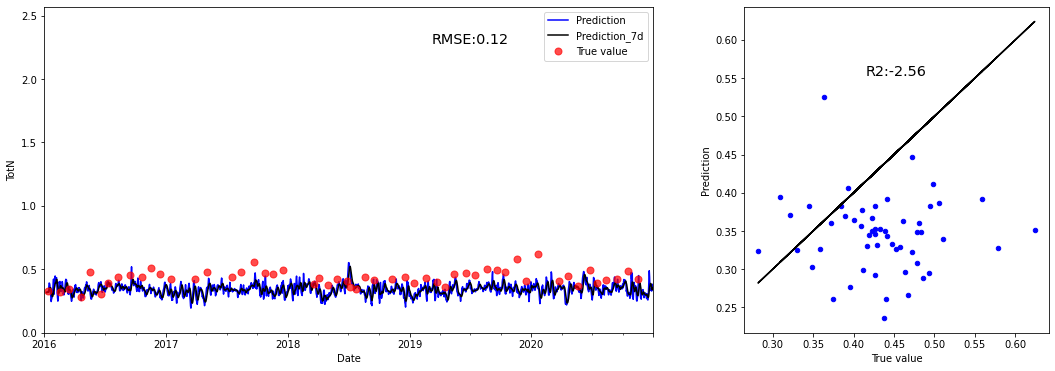

In [19]:
# predict nutreint 1
nutrient = input('Nutrient: ')
# If add the features from process-based model, add features 'MLD','W','thermD'
features.pop(0) # Remove 'Date'
features.append(nutrient)

Nut_memory = Daily_df.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                            how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [20]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,Air P,Air T,RelHum,CC,SWR,Prec,inflow(m3/s),outflow(m3/s),MLD,W,thermD,TotN
0,2007-01-02,0.006296,13.015444,1014.7,6.4,81.3,0.625,0.0,2.6,5.281766,8.838331,43.511112,0.023494,43.5111,0.131702
1,2007-01-03,0.001832,10.906222,1015.9,11.3,93.8,1.000,0.0,0.0,14.660707,8.537650,43.511112,0.000000,43.5111,0.131702
2,2007-01-04,0.004876,10.803333,1001.2,8.5,86.9,0.875,0.0,0.2,4.223394,9.868452,43.511112,0.004375,43.5111,0.131702
3,2007-01-05,0.003023,8.128222,1007.4,10.0,91.5,1.000,0.0,0.0,9.516208,8.592469,43.511112,0.000000,43.5111,0.131702
4,2007-01-06,0.000118,6.379111,1007.5,8.4,86.8,0.375,0.0,0.1,5.015504,7.191066,43.511112,0.006438,43.5111,0.131702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,2021-02-24,0.020578,13.581333,998.0,11.0,67.7,1.000,0.0,0.0,1.830783,6.287654,43.511112,0.036904,43.5111,0.438897
5168,2021-02-25,0.033311,3.395333,1012.3,5.9,89.1,1.000,0.0,0.0,1.303312,4.933820,43.511112,0.099891,43.5111,0.428678
5169,2021-02-26,0.085232,3.909778,1027.8,5.9,87.5,1.000,0.0,0.0,1.131633,3.911628,43.511112,1.902753,43.5111,0.404434
5170,2021-02-27,0.161147,1.440444,1032.6,8.1,93.5,1.000,0.0,0.1,3.240652,3.559375,43.511112,1.040881,43.5111,0.382225


Nutrient: TotP
['delT', 'U', 'Air P', 'Air T', 'RelHum', 'CC', 'SWR', 'Prec', 'inflow(m3/s)', 'outflow(m3/s)', 'MLD', 'W', 'thermD', 'TotN']
Delete features? (Y/N)N
Add features? (Y/N)N
(3286, 8, 14) (3286,) (1879, 8, 14) (1879,)
number of input timesteps: 8
number of features: 14
number of samples: 74
Test RMSE: 2.52
Test R2: -0.17
Training dataset RMSE 2.03 (+/- 0.33)
Training dataset R2 -0.56 (+/- 0.45)
Model takes 2 min to run


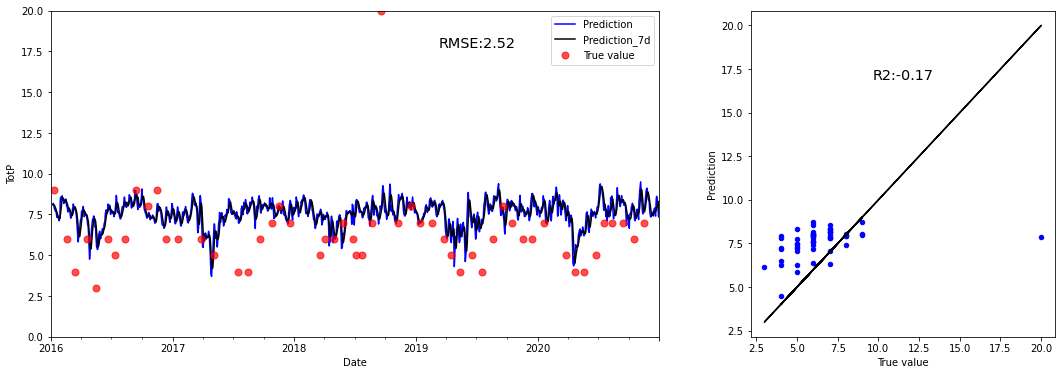

In [21]:
# predict nutreint 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates()
                              ,how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [22]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,Air P,Air T,RelHum,CC,SWR,Prec,inflow(m3/s),outflow(m3/s),MLD,W,thermD,TotN,TotP
0,2007-01-02,0.006296,13.015444,1014.7,6.4,81.3,0.625,0.0,2.6,5.281766,8.838331,43.511112,0.023494,43.5111,0.131702,7.726171
1,2007-01-03,0.001832,10.906222,1015.9,11.3,93.8,1.000,0.0,0.0,14.660707,8.537650,43.511112,0.000000,43.5111,0.131702,7.726171
2,2007-01-04,0.004876,10.803333,1001.2,8.5,86.9,0.875,0.0,0.2,4.223394,9.868452,43.511112,0.004375,43.5111,0.131702,7.726171
3,2007-01-05,0.003023,8.128222,1007.4,10.0,91.5,1.000,0.0,0.0,9.516208,8.592469,43.511112,0.000000,43.5111,0.131702,7.726171
4,2007-01-06,0.000118,6.379111,1007.5,8.4,86.8,0.375,0.0,0.1,5.015504,7.191066,43.511112,0.006438,43.5111,0.131702,7.726171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,2021-02-24,0.020578,13.581333,998.0,11.0,67.7,1.000,0.0,0.0,1.830783,6.287654,43.511112,0.036904,43.5111,0.438897,7.467353
5168,2021-02-25,0.033311,3.395333,1012.3,5.9,89.1,1.000,0.0,0.0,1.303312,4.933820,43.511112,0.099891,43.5111,0.428678,7.914784
5169,2021-02-26,0.085232,3.909778,1027.8,5.9,87.5,1.000,0.0,0.0,1.131633,3.911628,43.511112,1.902753,43.5111,0.404434,7.972293
5170,2021-02-27,0.161147,1.440444,1032.6,8.1,93.5,1.000,0.0,0.1,3.240652,3.559375,43.511112,1.040881,43.5111,0.382225,8.173524


Nutrient: PO4
['delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec(mm/d)', 'swr(w/m2)', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'MLD', 'W', 'thermD', 'NOX', 'O2']
Delete features? (Y/N)N
Add features? (Y/N)N
(4004, 8, 16) (4004,) (956, 8, 16) (956,)
number of input timesteps: 8
number of features: 16
number of samples: 364
Test RMSE: 0.25
Test R2: 0.64
Training dataset RMSE 0.21 (+/- 0.04)
Training dataset R2 0.77 (+/- 0.07)
Model takes 8 min to run


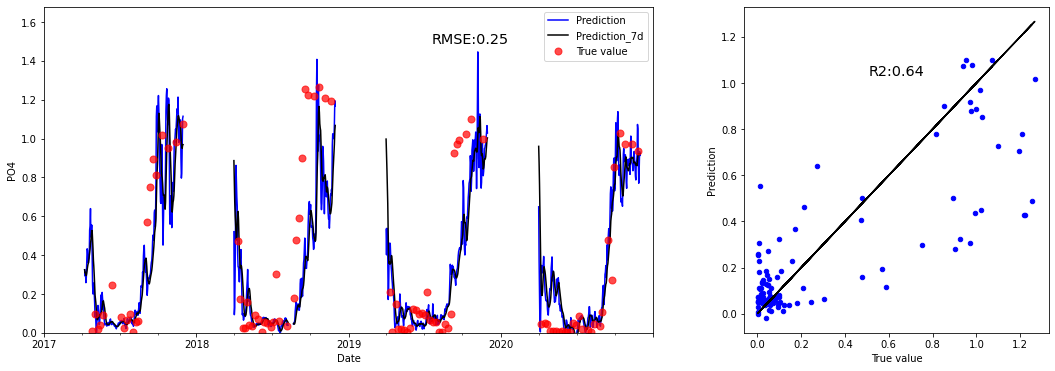

In [23]:
# predict nutreint 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [24]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,AirT,Humidity,CC,Prec(mm/d),swr(w/m2),inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,MLD,W,thermD,NOX,O2,PO4
0,1999-04-01,-0.310580,2.285000,4.097500,79.625000,0.541667,0.0,530.60,2.761,-2.327,110,-8.0,-21.0,0.017055,-15.0,11.254728,374.598724,0.492456
1,1999-04-02,-0.243210,2.896042,4.047917,82.520833,0.350000,0.0,558.20,2.547,-2.344,110,-7.0,-21.0,0.028323,-15.0,11.254728,374.598724,0.492456
2,1999-04-03,-0.125940,2.453667,2.879583,72.916667,0.354167,0.0,558.80,2.351,-2.345,110,-6.0,-21.0,0.005162,-15.0,11.254728,374.598724,0.492456
3,1999-04-04,0.014120,2.815458,1.517500,67.791667,0.412500,0.0,558.40,2.174,-2.331,110,-5.0,-21.0,0.031896,-15.0,11.254728,374.598724,0.492456
4,1999-04-05,0.126770,3.858375,4.116250,66.750000,0.487500,0.0,605.60,2.014,-2.304,110,-4.0,-21.0,0.024616,-15.0,11.254728,374.598724,0.492456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2020-11-26,0.111327,3.321292,5.930417,98.125000,0.845833,0.0,31.39,0.779,-0.465,5,291.0,-21.0,0.002728,-15.0,6.335045,342.776855,0.883651
4963,2020-11-27,0.063770,4.360500,2.672083,92.695833,0.945833,0.4,57.70,0.781,-0.450,5,292.0,-21.0,0.014944,-15.0,6.274883,340.118866,0.769982
4964,2020-11-28,-0.006724,2.387167,1.992500,92.887500,1.000000,0.2,52.75,0.773,-0.437,5,293.0,-21.0,0.002919,-15.0,6.448091,337.354797,0.837578
4965,2020-11-29,0.045284,2.114958,0.251667,99.500000,1.000000,0.7,32.69,0.789,-0.424,5,294.0,-21.0,0.028674,-15.0,6.329945,334.947083,0.932654


Nutrient: TotP
['delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec(mm/d)', 'swr(w/m2)', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'MLD', 'W', 'thermD', 'NOX', 'O2', 'PO4', 'TotP', 'NH4']
Delete features? (Y/N)Y
['delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec(mm/d)', 'swr(w/m2)', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'MLD', 'W', 'thermD', 'NOX', 'O2', 'PO4', 'TotP', 'NH4']
Location of the feature:-1
Delete features? (Y/N)Y
['delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec(mm/d)', 'swr(w/m2)', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'MLD', 'W', 'thermD', 'NOX', 'O2', 'PO4', 'TotP']
Location of the feature:-1
Delete features? (Y/N)N
Add features? (Y/N)N
(4004, 8, 17) (4004,) (956, 8, 17) (956,)
number of input timesteps: 8
number of features: 17
number of samples: 364
Test RMSE: 0.28
Test R2: 0.55
Training dataset RMSE 0.23 (+/- 0.02)
Training dataset R2 0.69 (+/- 0.06)
Model takes 9 min to run


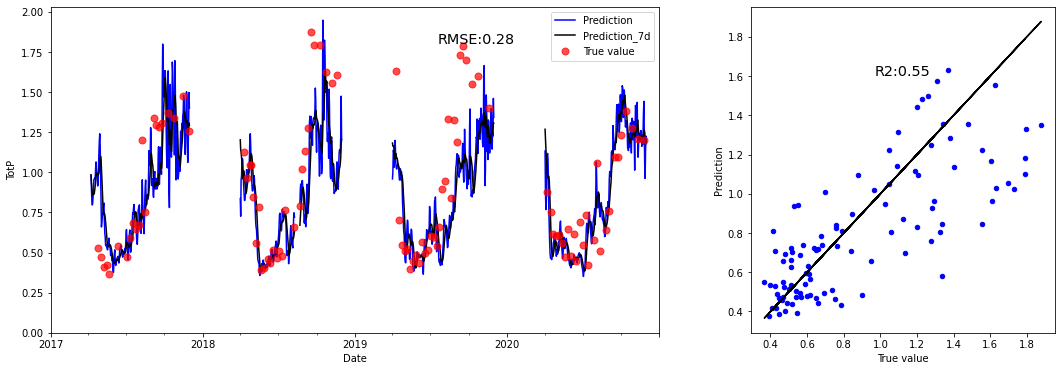

In [30]:
# predict nutreint 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [31]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,AirT,Humidity,CC,Prec(mm/d),swr(w/m2),inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,MLD,W,thermD,NOX,O2,PO4,TotP
0,1999-04-01,-0.310580,2.285000,4.097500,79.625000,0.541667,0.0,530.60,2.761,-2.327,110,-8.0,-21.0,0.017055,-15.0,11.254728,374.598724,0.492456,1.018381
1,1999-04-02,-0.243210,2.896042,4.047917,82.520833,0.350000,0.0,558.20,2.547,-2.344,110,-7.0,-21.0,0.028323,-15.0,11.254728,374.598724,0.492456,1.018381
2,1999-04-03,-0.125940,2.453667,2.879583,72.916667,0.354167,0.0,558.80,2.351,-2.345,110,-6.0,-21.0,0.005162,-15.0,11.254728,374.598724,0.492456,1.018381
3,1999-04-04,0.014120,2.815458,1.517500,67.791667,0.412500,0.0,558.40,2.174,-2.331,110,-5.0,-21.0,0.031896,-15.0,11.254728,374.598724,0.492456,1.018381
4,1999-04-05,0.126770,3.858375,4.116250,66.750000,0.487500,0.0,605.60,2.014,-2.304,110,-4.0,-21.0,0.024616,-15.0,11.254728,374.598724,0.492456,1.018381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2020-11-26,0.111327,3.321292,5.930417,98.125000,0.845833,0.0,31.39,0.779,-0.465,5,291.0,-21.0,0.002728,-15.0,6.335045,342.776855,0.883651,1.042237
4963,2020-11-27,0.063770,4.360500,2.672083,92.695833,0.945833,0.4,57.70,0.781,-0.450,5,292.0,-21.0,0.014944,-15.0,6.274883,340.118866,0.769982,0.961934
4964,2020-11-28,-0.006724,2.387167,1.992500,92.887500,1.000000,0.2,52.75,0.773,-0.437,5,293.0,-21.0,0.002919,-15.0,6.448091,337.354797,0.837578,1.131403
4965,2020-11-29,0.045284,2.114958,0.251667,99.500000,1.000000,0.7,32.69,0.789,-0.424,5,294.0,-21.0,0.028674,-15.0,6.329945,334.947083,0.932654,1.226374


Nutrient: NH4
['delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec(mm/d)', 'swr(w/m2)', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'MLD', 'W', 'thermD', 'NOX', 'O2', 'PO4', 'TotP']
Delete features? (Y/N)N
Add features? (Y/N)N
(4004, 8, 18) (4004,) (956, 8, 18) (956,)
number of input timesteps: 8
number of features: 18
number of samples: 364
Test RMSE: 0.79
Test R2: -0.13
Training dataset RMSE 0.94 (+/- 0.23)
Training dataset R2 -0.02 (+/- 0.10)
Model takes 10 min to run


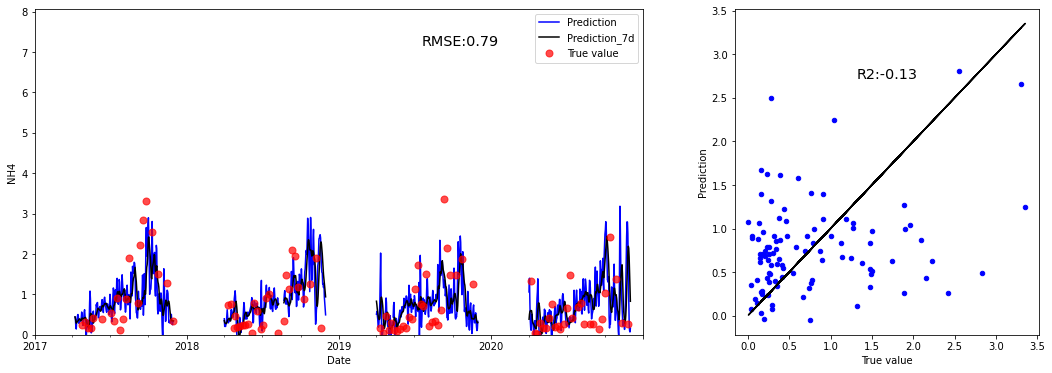

In [32]:
# predict nutreint 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [33]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,AirT,Humidity,CC,Prec(mm/d),swr(w/m2),inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,MLD,W,thermD,NOX,O2,PO4,TotP,NH4
0,1999-04-01,-0.310580,2.285000,4.097500,79.625000,0.541667,0.0,530.60,2.761,-2.327,110,-8.0,-21.0,0.017055,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150
1,1999-04-02,-0.243210,2.896042,4.047917,82.520833,0.350000,0.0,558.20,2.547,-2.344,110,-7.0,-21.0,0.028323,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150
2,1999-04-03,-0.125940,2.453667,2.879583,72.916667,0.354167,0.0,558.80,2.351,-2.345,110,-6.0,-21.0,0.005162,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150
3,1999-04-04,0.014120,2.815458,1.517500,67.791667,0.412500,0.0,558.40,2.174,-2.331,110,-5.0,-21.0,0.031896,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150
4,1999-04-05,0.126770,3.858375,4.116250,66.750000,0.487500,0.0,605.60,2.014,-2.304,110,-4.0,-21.0,0.024616,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2020-11-26,0.111327,3.321292,5.930417,98.125000,0.845833,0.0,31.39,0.779,-0.465,5,291.0,-21.0,0.002728,-15.0,6.335045,342.776855,0.883651,1.042237,0.924607
4963,2020-11-27,0.063770,4.360500,2.672083,92.695833,0.945833,0.4,57.70,0.781,-0.450,5,292.0,-21.0,0.014944,-15.0,6.274883,340.118866,0.769982,0.961934,0.369903
4964,2020-11-28,-0.006724,2.387167,1.992500,92.887500,1.000000,0.2,52.75,0.773,-0.437,5,293.0,-21.0,0.002919,-15.0,6.448091,337.354797,0.837578,1.131403,0.107625
4965,2020-11-29,0.045284,2.114958,0.251667,99.500000,1.000000,0.7,32.69,0.789,-0.424,5,294.0,-21.0,0.028674,-15.0,6.329945,334.947083,0.932654,1.226374,0.070389


Nutrient: Si
['delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec(mm/d)', 'swr(w/m2)', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'MLD', 'W', 'thermD', 'NOX', 'O2', 'PO4', 'TotP', 'NH4']
Delete features? (Y/N)N
Add features? (Y/N)N
(4004, 8, 19) (4004,) (956, 8, 19) (956,)
number of input timesteps: 8
number of features: 19
number of samples: 364
Test RMSE: 22.47
Test R2: -1.24
Training dataset RMSE 20.42 (+/- 0.90)
Training dataset R2 0.05 (+/- 0.17)
Model takes 10 min to run


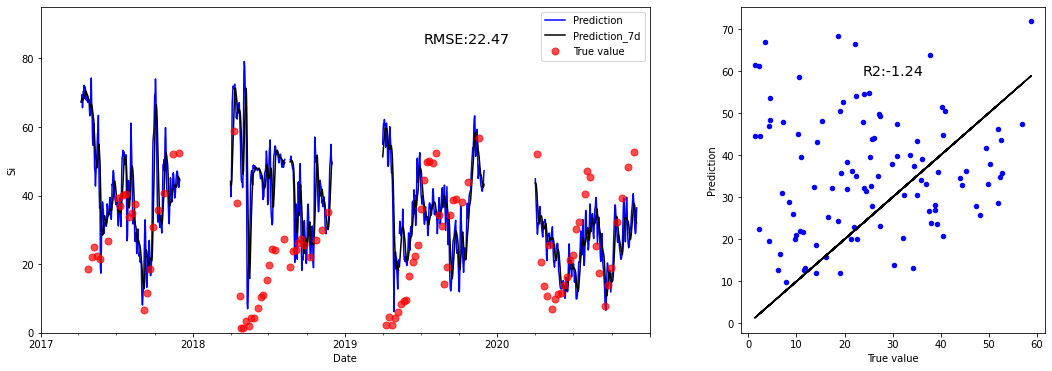

In [34]:
# predict nutreint 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [35]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,AirT,Humidity,CC,Prec(mm/d),swr(w/m2),inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,MLD,W,thermD,NOX,O2,PO4,TotP,NH4,Si
0,1999-04-01,-0.310580,2.285000,4.097500,79.625000,0.541667,0.0,530.60,2.761,-2.327,110,-8.0,-21.0,0.017055,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150,68.629639
1,1999-04-02,-0.243210,2.896042,4.047917,82.520833,0.350000,0.0,558.20,2.547,-2.344,110,-7.0,-21.0,0.028323,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150,68.629639
2,1999-04-03,-0.125940,2.453667,2.879583,72.916667,0.354167,0.0,558.80,2.351,-2.345,110,-6.0,-21.0,0.005162,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150,68.629639
3,1999-04-04,0.014120,2.815458,1.517500,67.791667,0.412500,0.0,558.40,2.174,-2.331,110,-5.0,-21.0,0.031896,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150,68.629639
4,1999-04-05,0.126770,3.858375,4.116250,66.750000,0.487500,0.0,605.60,2.014,-2.304,110,-4.0,-21.0,0.024616,-15.0,11.254728,374.598724,0.492456,1.018381,0.547150,68.629639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2020-11-26,0.111327,3.321292,5.930417,98.125000,0.845833,0.0,31.39,0.779,-0.465,5,291.0,-21.0,0.002728,-15.0,6.335045,342.776855,0.883651,1.042237,0.924607,29.926720
4963,2020-11-27,0.063770,4.360500,2.672083,92.695833,0.945833,0.4,57.70,0.781,-0.450,5,292.0,-21.0,0.014944,-15.0,6.274883,340.118866,0.769982,0.961934,0.369903,28.912415
4964,2020-11-28,-0.006724,2.387167,1.992500,92.887500,1.000000,0.2,52.75,0.773,-0.437,5,293.0,-21.0,0.002919,-15.0,6.448091,337.354797,0.837578,1.131403,0.107625,29.175886
4965,2020-11-29,0.045284,2.114958,0.251667,99.500000,1.000000,0.7,32.69,0.789,-0.424,5,294.0,-21.0,0.028674,-15.0,6.329945,334.947083,0.932654,1.226374,0.070389,32.283257


Nutrient: TOC
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 21) (4950,) (1093, 8, 21) (1093,)
number of input timesteps: 8
number of features: 21
number of samples: 99
Test RMSE: 0.86
Test R2: -0.42
Training dataset RMSE 0.71 (+/- 0.25)
Training dataset R2 0.08 (+/- 0.15)
Model takes 2 min to run


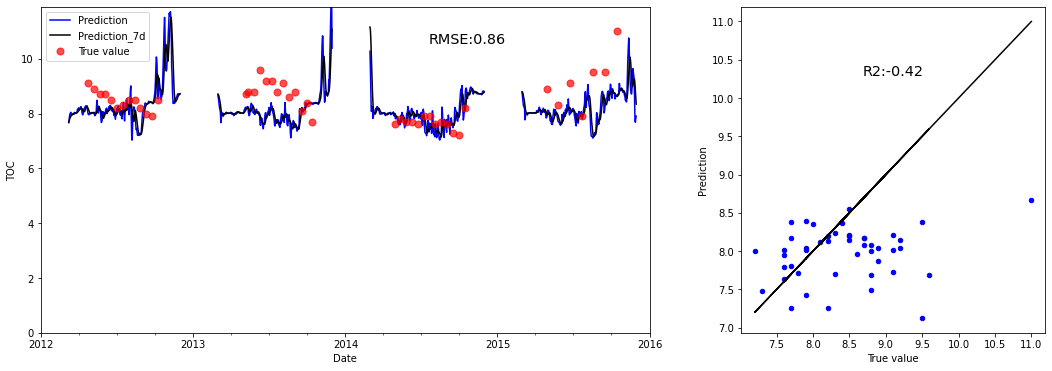

In [32]:
# predict nutreint 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
Scaler=MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [33]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,CC,Prec,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,O2,NO3N,NH4N,PO4P,TOTP,TOTN,TOC
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.458692,0.830272,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,0.854867,1.530000,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.993754,0.423039,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.708459,0.000784,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,1.000008,0.338688,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.548573,0.000000,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,8.872602,55.972729,15.604255,8.623958,31.749716,784.934448,8.587276
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.968004,0.001345,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,8.792369,16.538393,19.361982,7.025309,29.891218,702.546997,7.742613
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.634158,0.003703,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,8.806619,158.694748,22.888605,6.790660,29.994944,729.221436,7.682547
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.928686,0.000335,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,8.846630,190.166748,22.555815,6.788723,28.392122,764.089233,7.832428


Nutrient: SiO2
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN', 'TOC']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 22) (4950,) (1093, 8, 22) (1093,)
number of input timesteps: 8
number of features: 22
number of samples: 167
Test RMSE: 1.15
Test R2: 0.43
Training dataset RMSE 0.83 (+/- 0.18)
Training dataset R2 0.51 (+/- 0.15)
Model takes 4 min to run


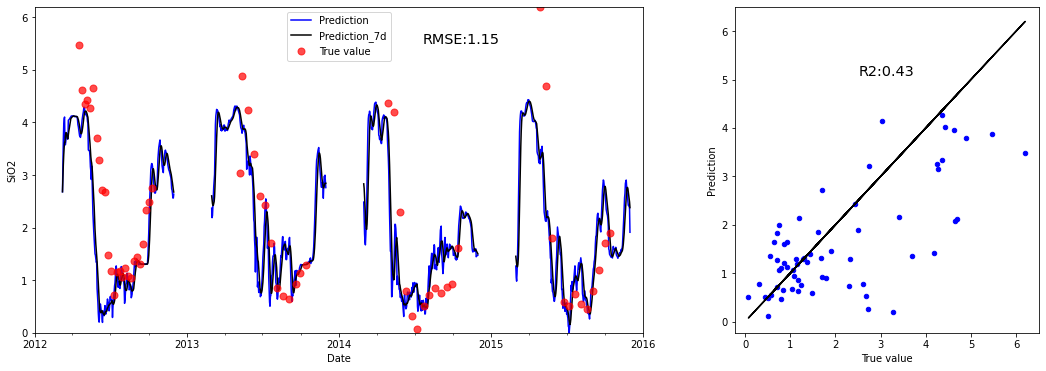

In [34]:
# predict nutreint 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [35]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,CC,Prec,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,O2,NO3N,NH4N,PO4P,TOTP,TOTN,TOC,SiO2
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.458692,0.830272,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,0.854867,1.530000,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.993754,0.423039,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.708459,0.000784,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,1.000008,0.338688,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.548573,0.000000,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,8.872602,55.972729,15.604255,8.623958,31.749716,784.934448,8.587276,2.421144
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.968004,0.001345,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,8.792369,16.538393,19.361982,7.025309,29.891218,702.546997,7.742613,2.417079
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.634158,0.003703,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,8.806619,158.694748,22.888605,6.790660,29.994944,729.221436,7.682547,2.430667
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.928686,0.000335,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,8.846630,190.166748,22.555815,6.788723,28.392122,764.089233,7.832428,2.352034


Nutrient: Chl
['delT', 'U', 'Air P', 'Air T', 'RelHum', 'CC', 'SWR', 'Prec', 'inflow(m3/s)', 'outflow(m3/s)', 'MLD', 'W', 'thermD', 'TotN', 'TotP']
Delete features? (Y/N)N
Add features? (Y/N)n
(3286, 8, 15) (3286,) (1879, 8, 15) (1879,)
number of input timesteps: 8
number of features: 15
number of samples: 88
Test RMSE: 0.37
Test R2: 0.66
Training dataset RMSE 0.54 (+/- 0.18)
Training dataset R2 0.52 (+/- 0.15)
Model takes 3 min to run


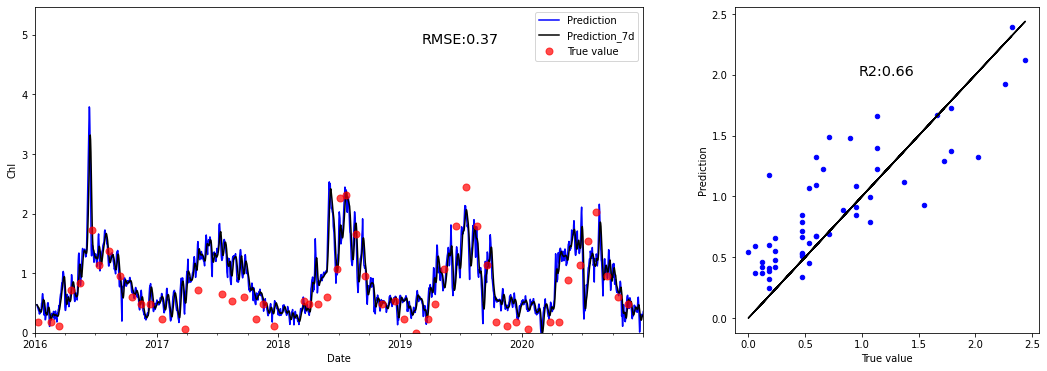

In [23]:
# predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
Scaler = MinMaxScaler()#PowerTransformer(standardize=False)
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_scaled],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [24]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,Air P,Air T,RelHum,CC,SWR,Prec,inflow(m3/s),outflow(m3/s),MLD,W,thermD,TotN,TotP,Chl
0,2007-01-02,0.006296,13.015444,1014.7,6.4,81.3,0.625,0.0,2.6,5.281766,8.838331,43.511112,0.023494,43.5111,0.131702,7.726171,0.701292
1,2007-01-03,0.001832,10.906222,1015.9,11.3,93.8,1.000,0.0,0.0,14.660707,8.537650,43.511112,0.000000,43.5111,0.131702,7.726171,0.701292
2,2007-01-04,0.004876,10.803333,1001.2,8.5,86.9,0.875,0.0,0.2,4.223394,9.868452,43.511112,0.004375,43.5111,0.131702,7.726171,0.701292
3,2007-01-05,0.003023,8.128222,1007.4,10.0,91.5,1.000,0.0,0.0,9.516208,8.592469,43.511112,0.000000,43.5111,0.131702,7.726171,0.701292
4,2007-01-06,0.000118,6.379111,1007.5,8.4,86.8,0.375,0.0,0.1,5.015504,7.191066,43.511112,0.006438,43.5111,0.131702,7.726171,0.701292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,2021-02-24,0.020578,13.581333,998.0,11.0,67.7,1.000,0.0,0.0,1.830783,6.287654,43.511112,0.036904,43.5111,0.438897,7.467353,0.371179
5168,2021-02-25,0.033311,3.395333,1012.3,5.9,89.1,1.000,0.0,0.0,1.303312,4.933820,43.511112,0.099891,43.5111,0.428678,7.914784,0.469642
5169,2021-02-26,0.085232,3.909778,1027.8,5.9,87.5,1.000,0.0,0.0,1.131633,3.911628,43.511112,1.902753,43.5111,0.404434,7.972293,0.501790
5170,2021-02-27,0.161147,1.440444,1032.6,8.1,93.5,1.000,0.0,0.1,3.240652,3.559375,43.511112,1.040881,43.5111,0.382225,8.173524,0.559281


In [25]:
Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',index = False)